In [1]:
# ===============================================
# 🧾 0. Setup and Library Imports
# ===============================================

import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf

# -----------------------------------------------
# 🔒 Ensure reproducibility across runs
# -----------------------------------------------
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
os.environ["PYTHONHASHSEED"] = str(seed_value)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
tf.random.set_seed(seed_value)

In [2]:
# ===============================================
# 📂 1. Define Paths
# ===============================================

base_dir = "C:/Users/Kuhn/Desktop/Post-Uni/Data Scientest/Projekte/Tiere"
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")
test_dir  = os.path.join(base_dir, "test")

train_csv = os.path.join(train_dir, "_annotations.csv")
valid_csv = os.path.join(valid_dir, "_annotations.csv")
test_csv  = os.path.join(test_dir, "_annotations.csv")

# output directories for cropped images
train_crop_dir = os.path.join(train_dir, "cropped")
valid_crop_dir = os.path.join(valid_dir, "cropped")
test_crop_dir  = os.path.join(test_dir, "cropped")
os.makedirs(train_crop_dir, exist_ok=True)
os.makedirs(valid_crop_dir, exist_ok=True)
os.makedirs(test_crop_dir, exist_ok=True)


In [3]:
# ===============================================
# 📄 2. Load and Preprocess All Sets
# ===============================================

def load_and_crop(csv_path, base_path, save_dir):
    df = pd.read_csv(csv_path)
    df["label"] = df["class"].apply(lambda x: "dog" if "dog" in x else "cat")

    new_rows = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Cropping {base_path}"):
        img_path = os.path.join(base_path, row["filename"])
        img = Image.open(img_path)
        xmin, ymin, xmax, ymax = row["xmin"], row["ymin"], row["xmax"], row["ymax"]
        cropped = img.crop((xmin, ymin, xmax, ymax))
        new_filename = f"crop_{row['filename']}"
        save_path = os.path.join(save_dir, new_filename)
        cropped.save(save_path)
        new_rows.append({"filepath": save_path, "label": row["label"]})
    
    cropped_df = pd.DataFrame(new_rows)
    return cropped_df

train_df = load_and_crop(train_csv, train_dir, train_crop_dir)
valid_df = load_and_crop(valid_csv, valid_dir, valid_crop_dir)
test_df  = load_and_crop(test_csv,  test_dir,  test_crop_dir)



Cropping C:/Users/Kuhn/Desktop/Post-Uni/Data Scientest/Projekte/Tiere\train: 100%|██████████| 12899/12899 [02:31<00:00, 84.93it/s]
Cropping C:/Users/Kuhn/Desktop/Post-Uni/Data Scientest/Projekte/Tiere\valid: 100%|██████████| 738/738 [00:09<00:00, 81.34it/s] 
Cropping C:/Users/Kuhn/Desktop/Post-Uni/Data Scientest/Projekte/Tiere\test: 100%|██████████| 368/368 [00:04<00:00, 77.88it/s]


In [4]:
# ===============================================
# ⚖️ 3. Oversample Minority Class (Cats)
# ===============================================

cats = train_df[train_df["label"] == "cat"]
dogs = train_df[train_df["label"] == "dog"]
cats_up = resample(cats, replace=True, n_samples=len(dogs), random_state=42)
train_balanced = pd.concat([dogs, cats_up]).reset_index(drop=True)
print("Balanced train set:\n", train_balanced["label"].value_counts())


Balanced train set:
 label
dog    8814
cat    8814
Name: count, dtype: int64


In [5]:
# ===============================================
# 🧠 4. Image Data Generators
# ===============================================

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_balanced,
    x_col="filepath",
    y_col="label",
    target_size=(128, 128),
    class_mode="binary",
    batch_size=32,
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col="filepath",
    y_col="label",
    target_size=(128, 128),
    class_mode="binary",
    batch_size=32,
    shuffle=False
)

test_gen = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(128, 128),
    class_mode="binary",
    batch_size=32,
    shuffle=False
)


Found 17628 validated image filenames belonging to 2 classes.
Found 738 validated image filenames belonging to 2 classes.
Found 368 validated image filenames belonging to 2 classes.


In [6]:
# ===============================================
# ⚙️ 5. CNN Model Architecture
# ===============================================

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


c:\Users\Kuhn\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,449 (28.20 MB)

 Trainable params: 7,392,449 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# ===============================================
# 🏋️ 6. Model Training
# ===============================================

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

Epoch 1/10


c:\Users\Kuhn\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


551/551 ━━━━━━━━━━━━━━━━━━━━ 104s 187ms/step - accuracy: 0.7806 - loss: 0.4598 - val_accuracy: 0.8889 - val_loss: 0.2771
Epoch 2/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 116s 210ms/step - accuracy: 0.8926 - loss: 0.2679 - val_accuracy: 0.9011 - val_loss: 0.2432
Epoch 3/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 118s 215ms/step - accuracy: 0.9294 - loss: 0.1869 - val_accuracy: 0.9079 - val_loss: 0.2239
Epoch 4/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 121s 219ms/step - accuracy: 0.9491 - loss: 0.1436 - val_accuracy: 0.9201 - val_loss: 0.2181
Epoch 5/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 119s 216ms/step - accuracy: 0.9623 - loss: 0.1122 - val_accuracy: 0.9295 - val_loss: 0.2191
Epoch 6/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 112s 203ms/step - accuracy: 0.9697 - loss: 0.0921 - val_accuracy: 0.9255 - val_loss: 0.2247
Epoch 7/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 117s 213ms/step - accuracy: 0.9774 - loss: 0.0737 - val_accuracy: 0.9282 - val_loss: 0.2516
Epoch 8/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 123s 223ms/step - accuracy: 0.9826 - loss: 0.05

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


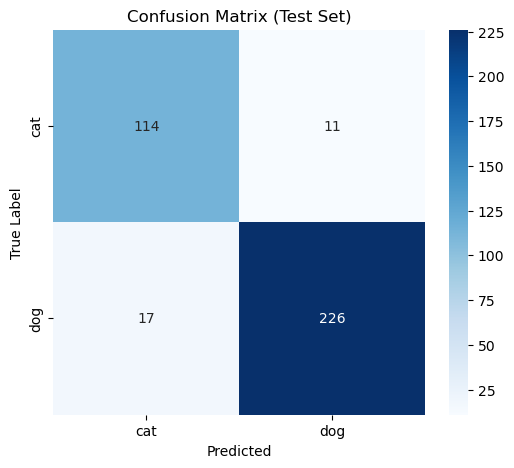


Classification Report (Test Set):

              precision    recall  f1-score   support

         cat       0.87      0.91      0.89       125
         dog       0.95      0.93      0.94       243

    accuracy                           0.92       368
   macro avg       0.91      0.92      0.92       368
weighted avg       0.93      0.92      0.92       368



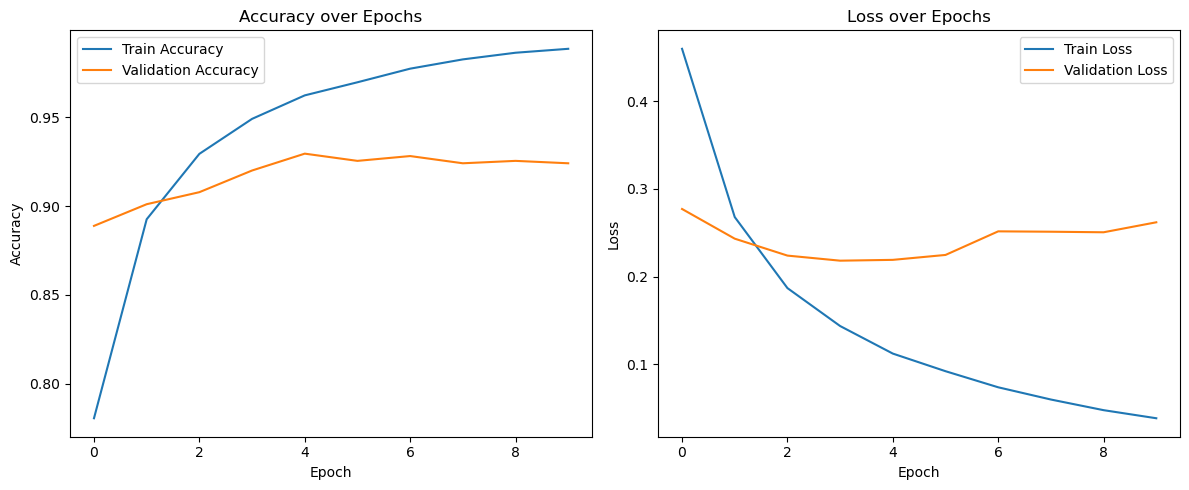

In [ ]:
# ===============================================
# 🧾 7. Model Evaluation (Test Set)
# ===============================================

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# --- Generate predictions ---
test_gen.reset()
y_true = test_gen.classes
y_pred_prob = model.predict(test_gen, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

# --- Confusion matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.show()

# --- Classification report ---
print("\nClassification Report (Test Set):\n")
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

# --- Accuracy and loss curves (Training/Validation) ---
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


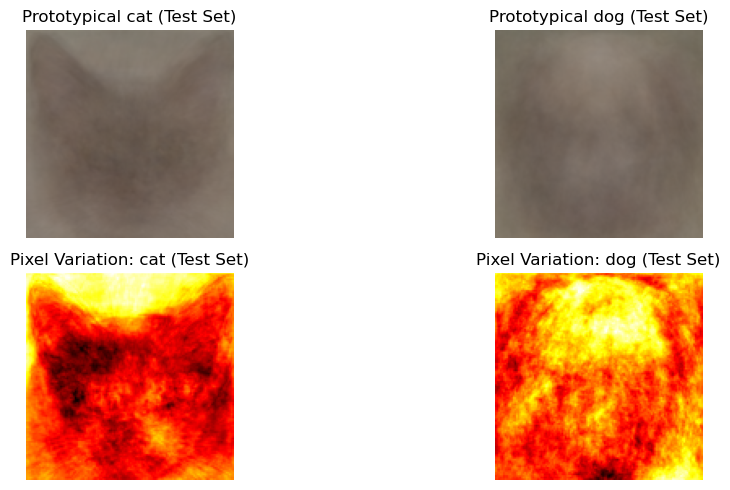

In [14]:
# ===============================================
# 🧩 11. Prototypical Images and Heatmaps (Test Set)
# ===============================================

def compute_average_and_heatmap(df_subset):
    imgs = []
    for filepath in df_subset["filepath"]:
        try:
            img = Image.open(filepath).resize((128,128))
            img_array = np.array(img) / 255.0
            imgs.append(img_array)
        except Exception as e:
            print(f"⚠️ Error loading {filepath}: {e}")
    
    imgs_array = np.stack(imgs, axis=0)
    avg_img = np.mean(imgs_array, axis=0)
    heatmap = np.mean(np.std(imgs_array, axis=0), axis=2)
    return avg_img, heatmap


plt.figure(figsize=(12,5))
for i, label in enumerate(["cat", "dog"]):
    subset = test_df[test_df["label"] == label]
    avg_img, heatmap = compute_average_and_heatmap(subset)
    
    plt.subplot(2,2,i+1)
    plt.imshow(avg_img)
    plt.title(f"Prototypical {label} (Test Set)")
    plt.axis("off")
    
    plt.subplot(2,2,i+3)
    plt.imshow(heatmap, cmap="hot")
    plt.title(f"Pixel Variation: {label} (Test Set)")
    plt.axis("off")

plt.tight_layout()
plt.show()

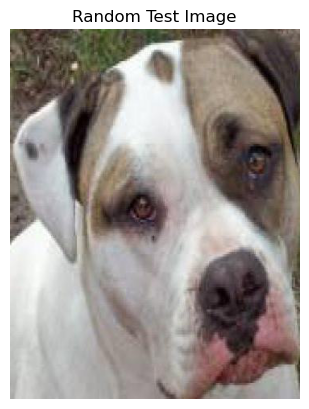

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted label: dog (Probability of dog: 1.000)


In [28]:
# ===============================================
# 🔍 12. Random Image Prediction (from Test Set)
# ===============================================

def predict_single_image(img_path, model, target_size=(128,128)):
    img = Image.open(img_path).resize(target_size)
    img_array = np.expand_dims(np.array(img)/255.0, axis=0)
    prob = model.predict(img_array)[0][0]
    label = "dog" if prob > 0.5 else "cat"
    return label, prob


def predict_random_image(df, model, target_size=(128,128)):
    row = df.sample(n=1).iloc[0]
    img_path = row["filepath"]
    
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Random Test Image")
    plt.show()
    
    label, prob = predict_single_image(img_path, model, target_size)
    print(f"Predicted label: {label} (Probability of dog: {prob:.3f})")


# Example prediction from the test set
predict_random_image(test_df, model)